In [1]:
import random
import string
import re
import nltk
import torch

import copy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from nlp_project.notebook_utils import evaluate, split, save_scikit_model, load_scikit_model
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
# Saved Models path
models_path = "./models/T2_BoW_Models"

# Classification labels
labels = ["A", "B", "C", "D", "E", "F"]

In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_2/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,It was not until many years later that it coul...,A
1,Users can then pin these images to their profi...,F
2,The best songs are those that I can sing along...,B
3,I found this book to be poorly written. It was...,D
4,Regulates the application of the EU tariff quo...,E
...,...,...
22411,The ministry had earlier said it was working w...,B
22412,"Once combined, slowly add the melted butter, s...",F
22413,Hightower for this new and wellwritten book!. ...,B
22414,All throughout the whole book this author has ...,D


In [5]:
def preprocess(data, lower=True, vectorizer=None, fit=True):
    # Convert all text to lowercase
    if lower:
        data = [x.lower() for x in data]

    # Remove punctuation and reset multiple spaces to one
    punct_regex = re.compile("[" + string.punctuation + "\’'" + "]")
    whitespace_regex = re.compile(" ( )+")
    data = [whitespace_regex.sub(" ", punct_regex.sub(" ", x)) for x in data]
    
    # Vectorize
    if vectorizer:
        if fit:
            data = vectorizer.fit_transform(data)
        else:
            data = vectorizer.transform(data)
    
    return data

In [6]:
vectorizer = TfidfVectorizer(min_df=4, max_df=0.6, ngram_range=(2,2))

In [7]:
x, y = df["text"], df["label"]
x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train = preprocess(x_train, vectorizer=vectorizer)
x_test = preprocess(x_test, vectorizer=vectorizer, fit=False)

In [8]:
models = []
usecached = False

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Naive Bayes",
    "model": nb_clf,
    "usecached": usecached,
})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Linear Regression",
    "model": lr_clf,
    "subsample": 0.9,
    "usecached": usecached,
})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "SVC",
    "model": svc_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Extra Trees",
    "model": et_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

In [9]:
for model in models:
    if model["usecached"]:
        cache = load_scikit_model(models_path, model["name"])
        if cache:
            model["best"] = cache
            print(f"Restored model for {model['name']}")
            continue
        else:
            print(f"Couldn't restore model for {model['name']}")
            
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
            
    print(f"Training {model['name']}")        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")
    
    save_scikit_model(models_path, model["best"], model["name"])

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.37848582855826124
              precision    recall  f1-score   support

           A       0.49      0.41      0.45       712
           B       0.30      0.29      0.29       730
           C       0.28      0.25      0.26       737
           D       0.31      0.40      0.35       774
           E       0.31      0.32      0.31       765
           F       0.61      0.58      0.60       766

    accuracy                           0.38      4484
   macro avg       0.38      0.37      0.38      4484
weighted avg       0.38      0.38      0.38      4484



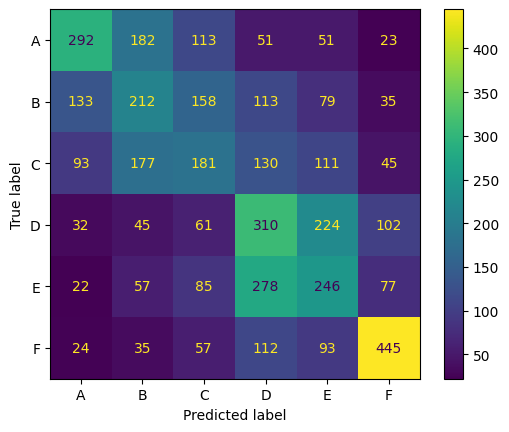

Linear Regression
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best CV score: 0.2956194270241671
              precision    recall  f1-score   support

           A       0.47      0.51      0.49       712
           B       0.35      0.32      0.33       730
           C       0.34      0.28      0.30       737
           D       0.34      0.37      0.36       774
           E       0.33      0.33      0.33       765
           F       0.57      0.63      0.60       766

    accuracy                           0.41      4484
   macro avg       0.40      0.41      0.40      4484
weighted avg       0.40      0.41      0.40      4484



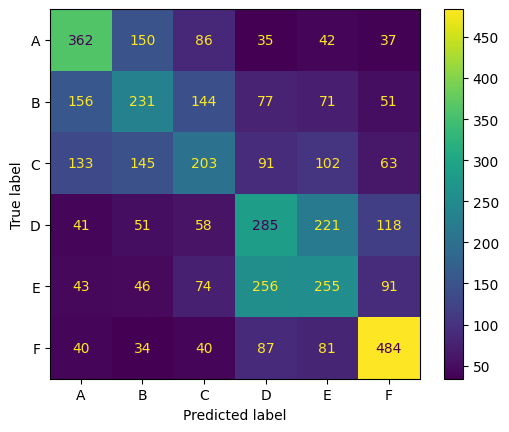

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.3506680467880591
              precision    recall  f1-score   support

           A       0.48      0.49      0.49       712
           B       0.33      0.34      0.33       730
           C       0.33      0.30      0.32       737
           D       0.34      0.36      0.35       774
           E       0.33      0.35      0.34       765
           F       0.62      0.59      0.60       766

    accuracy                           0.40      4484
   macro avg       0.41      0.40      0.40      4484
weighted avg       0.41      0.40      0.40      4484



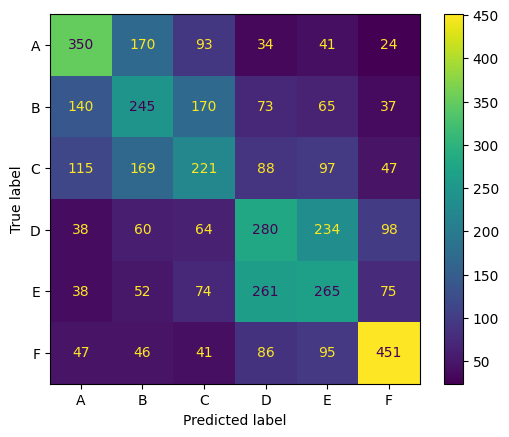

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.33100899508696224
              precision    recall  f1-score   support

           A       0.39      0.54      0.45       712
           B       0.29      0.17      0.21       730
           C       0.24      0.11      0.15       737
           D       0.31      0.43      0.36       774
           E       0.27      0.24      0.25       765
           F       0.47      0.62      0.54       766

    accuracy                           0.35      4484
   macro avg       0.33      0.35      0.33      4484
weighted avg       0.33      0.35      0.33      4484



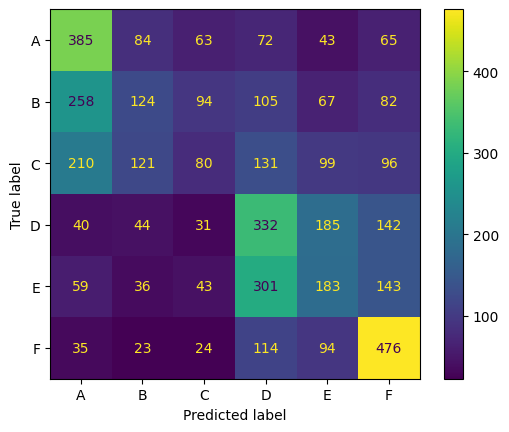

In [10]:
for model in models:
    print(f"{model['name']}")
    if hasattr(model["model"], "cv_results_"):
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [11]:
epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [12]:
y_ = LabelEncoder().fit_transform(y).astype(float)

x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y_, test_size=0.1, val_size=0.1, seed=seed
)

x_train = preprocess(x_train, vectorizer=vectorizer)
x_val = preprocess(x_val, vectorizer=vectorizer, fit=False)
x_test = preprocess(x_test, vectorizer=vectorizer, fit=False)

In [13]:
ds_train = Data(x_train, y_train, x_type=np.float32, y_type=torch.long)
ds_val = Data(x_val, y_val, x_type=np.float32, y_type=torch.long)
ds_test = Data(x_test, y_test, x_type=np.float32, y_type=torch.long)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

/home/riga/Documents/NLP/NLP_Project/nlp_project/nn_classifier.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.LongTensor([x_coo.row, x_coo.col]),


In [15]:
in_dim = x_train.shape[1]
out_dim = 1 if len(labels) <= 2 else len(labels)

In [16]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.5)
        
        self.relu = nn.ReLU()
        self.sm = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sm(self.l3(x))
        return x

In [17]:
nn_model = Network(in_dim, out_dim, binary_classifier=False, device=device)
loss = nn.CrossEntropyLoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.01)
nn_model.compile(loss, optimizer)

In [18]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.3)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]

# nn_model.load_state_dict(torch.load(models_path + "NN Model"))
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0548405 acc: 0.3001896 val_loss: 0.0550453 val_acc: 0.3037466
Epoch 2 -- loss: 0.0531144 acc: 0.4356458 val_loss: 0.0552737 val_acc: 0.3327386
Epoch 3 -- loss: 0.0525239 acc: 0.4618559 val_loss: 0.0556849 val_acc: 0.3113292
Epoch 4 -- loss: 0.0523525 acc: 0.4813741 val_loss: 0.0556146 val_acc: 0.3046387
Epoch 5 -- loss: 0.0523078 acc: 0.4819875 val_loss: 0.0554454 val_acc: 0.3171276
Epoch 6 -- loss: 0.0522424 acc: 0.4994423 val_loss: 0.0553327 val_acc: 0.3117752
Reducing lr to 0.0010
Epoch 7 -- loss: 0.0522014 acc: 0.4965425 val_loss: 0.0554450 val_acc: 0.3006244
Epoch 8 -- loss: 0.0522269 acc: 0.4915235 val_loss: 0.0554007 val_acc: 0.3157895
Epoch 9 -- loss: 0.0521344 acc: 0.5060785 val_loss: 0.0554673 val_acc: 0.3024086
Epoch 10 -- loss: 0.0521110 acc: 0.5142204 val_loss: 0.0554453 val_acc: 0.3198037
Epoch 11 -- loss: 0.0521137 acc: 0.5079188 val_loss: 0.0552103 val_acc: 0.3166815
Model restored successfully @ epoch 2


{'acc': tensor(0.3113), 'loss': 0.05546400166323523}
              precision    recall  f1-score   support

         0.0       0.39      0.33      0.36       356
         1.0       0.24      0.27      0.25       365
         2.0       0.22      0.26      0.24       368
         3.0       0.33      0.33      0.33       387
         4.0       0.27      0.31      0.29       383
         5.0       0.52      0.36      0.43       383

    accuracy                           0.31      2242
   macro avg       0.33      0.31      0.32      2242
weighted avg       0.33      0.31      0.32      2242



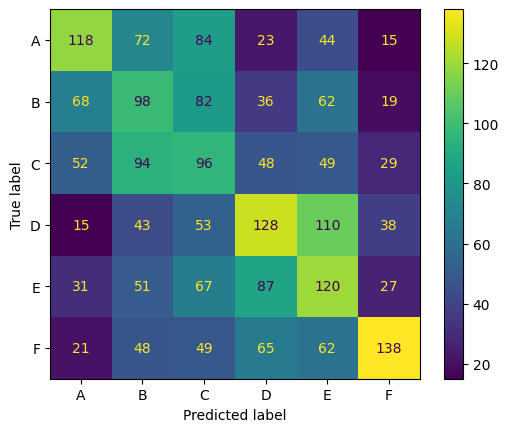

In [19]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

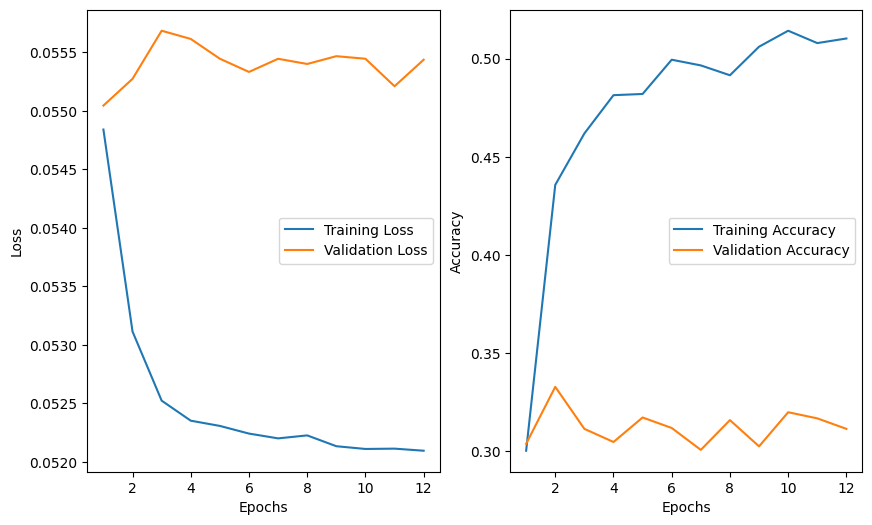

In [20]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

In [21]:
torch.save(nn_model.state_dict(), models_path + "/" + "NN Model")